In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
class Value:
    def __init__(self,data,op = None,label = None,children = set()):
        self.data = data
        self.op = op
        self.label = label
        self.children = list(i for i in children)
        self.grad = 0
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data = {self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(data = self.data + other.data, op = '+',children = {self,other})
        
        def _backward():
            self.grad += out.grad * 1
            other.grad += out.grad * 1
            
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        out = self + other
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(data = self.data * other.data, op = '*',children = {self,other})
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        out = self * other
        return out
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other): 
        return self + (-other)

    def __rsub__(self, other):
        return other + (-self)

    
    def __pow__(self,other):
        other = other if isinstance(other,Value) else Value(other)
        out = Value(data = (self.data)**(other.data),op = f"^{other.data}",children = {self})
        
        def _backward():
            self.grad += out.grad * ((other.data)*(self.data)**(other.data - 1))
            
        out._backward = _backward
        return out
    
    def __truediv__(self,other):
        return self * (other)**(-1)
    
    def exp(self):
        z = math.exp(self.data)
        out = Value(z,op = "e^",children = {self})
        
        def _backward():
            self.grad += out.grad * z
            
        out._backward = _backward
        return out
    
    def relu(self):
        z = max(0,self.data)
        out = Value(z,op = 'relu',children = {self})
        
        def _backward():
            if self.data <= 0:
                self.grad = out.grad * 0
            else:
                self.grad = out.grad * 1
                
        out._backward = _backward
        return out
    
    def tanh(self):
        z = self.data
        t = (math.exp(2 * z) - 1)/(math.exp(2 * z) + 1)
        out = Value(t, op = 'tanh',children = {self})
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out
     
    def backward(self):
        visited = set()
        nodes = []
        def topo(root):
            if root not in visited:
                visited.add(root)
                nodes.append(root)
                for child in root.children:
                    if child is visited:
                        continue
                    else:
                        topo(child)
        topo(self)
        self.grad = 1
        for node in nodes:
            node._backward()

w = Value(-3,label = "w")
x = Value(2, label = "x")
a = w * x; a.label = "a"
b = Value(1,label = "b")
c = a + b; c.label = "c"
d = -1 * c; d.label = "d"
y = Value(1,label = "y")
e = d + y; e.label = "e"
l = e**2; l.label = "l"
l

Value(data = 36)

In [18]:
import graphviz

In [19]:
from graphviz import Digraph

In [20]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v.children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
    if n.op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n.op, label = n.op)
      # and connect this node to it
      dot.edge(uid + n.op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2.op)

  return dot

In [21]:
l.backward()

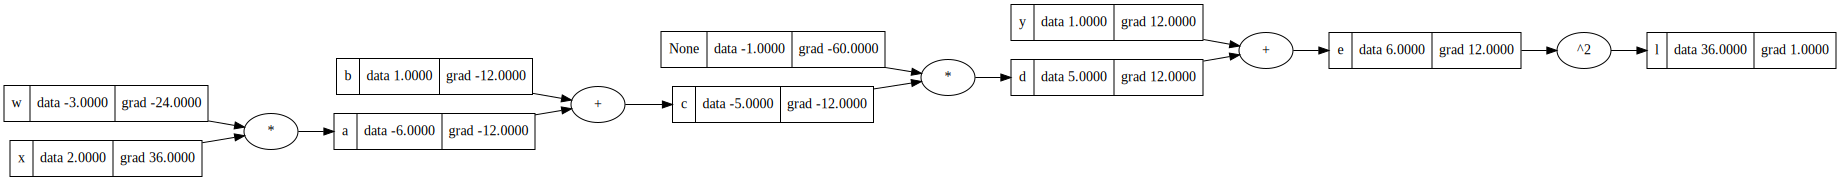

In [22]:
draw_dot(l)

In [23]:
#using a neuron:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
output = n.relu(); output.label = 'o'

In [24]:
output.backward()

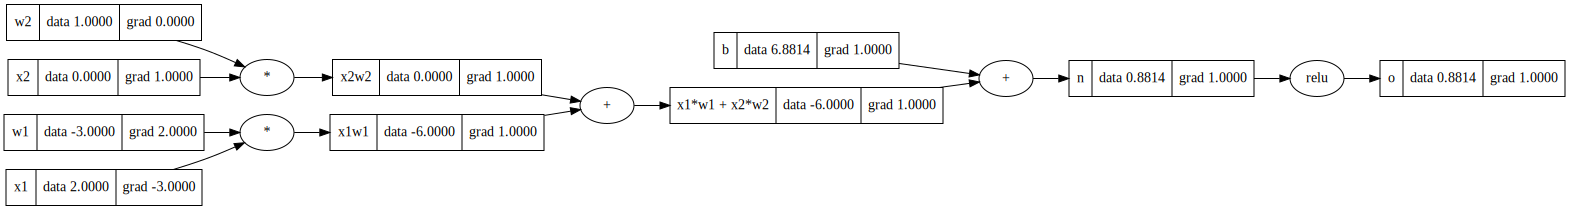

In [25]:
draw_dot(output)

In [26]:
import random

In [27]:
class Module:

    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):

    def __init__(self, nin, nonlin=True):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(0)
        self.nonlin = nonlin

    def __call__(self, x):
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        return act.relu() if self.nonlin else act

    def parameters(self):
        return self.w + [self.b]

    def __repr__(self):
        return f"{'ReLU' if self.nonlin else 'Linear'}Neuron({len(self.w)})"

class Layer(Module):

    def __init__(self, nin, nout, **kwargs):
        self.neurons = [Neuron(nin, **kwargs) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

    def __repr__(self):
        return f"Layer of [{', '.join(str(n) for n in self.neurons)}]"

class MLP(Module):

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1], nonlin=i!=len(nouts)-1) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        return f"MLP of [{', '.join(str(layer) for layer in self.layers)}]"

In [28]:
n = MLP(3, [4, 4, 1])
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
y_pred = [n(x) for x in xs]
y_pred

[Value(data = 0.20617100001956645),
 Value(data = 1.4396756621284954),
 Value(data = 0.06857547437832179),
 Value(data = 0.08498672329446187)]

In [29]:
def loss_fn(y_pred, y, errors = False):
    errors = [(yout - ygt)**2 for ygt, yout in zip(y, y_pred)]
    loss = sum(errors)
    return loss if errors else (loss, errors)

loss = loss_fn(y_pred, ys)
loss

Value(data = 8.56128465858231)

In [30]:
lr = 0.05
num_epochs = 10
losses = []

for epoch in range(num_epochs):
    # zero grad (since they sum up +=)
    for p in n.parameters():
        p.grad = 0.0

    # forward passp
    y_pred = [n(x) for x in xs]

    # loss
    loss = loss_fn(y_pred, ys)
    losses.append(loss.data)

    # backward pass
    loss.backward()

    # update parameters (Optimizer.Step)
    for p in n.parameters():
        p.data -= lr * p.grad
    
    print(epoch, loss)
    

print(loss)
y_pred = [n(x) for x in xs]
y_pred

0 Value(data = 8.56128465858231)
1 Value(data = 6.23286099568918)
2 Value(data = 4.066263817098931)
3 Value(data = 3.657908448396627)
4 Value(data = 3.493113406567834)
5 Value(data = 3.3369859194139293)
6 Value(data = 3.092350283593253)
7 Value(data = 2.868366941304589)
8 Value(data = 2.774135937086446)
9 Value(data = 2.7163842109129135)
Value(data = 2.7163842109129135)


[Value(data = 0.24089733842707783),
 Value(data = -0.9606839553374542),
 Value(data = 0.24089733842707783),
 Value(data = 0.24089733842707783)]

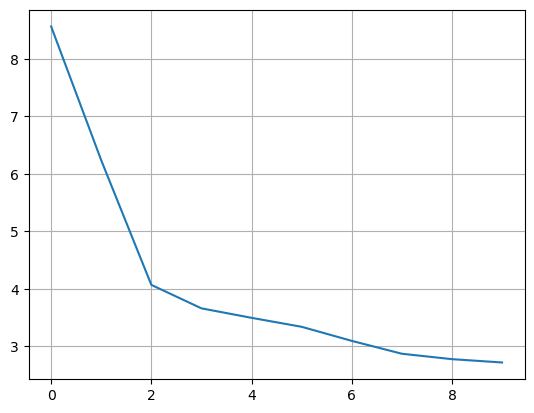

In [31]:
plt.plot(losses)
plt.grid()